# **ALGORITMO VORAZ CON ACTUALIZACIONES DE RANGO UNO**

En este cuaderno se exponen los ejemplos presentados en el póster *Análisis de un algoritmo voraz con actualizaciones de rango uno para la resolución de sistemas lineales de altas dimensiones*

Este cuaderno está asociado al de la memoria y contiene la construcción de un ejemplo que desarrolla uno de los presentados en el otro cuaderno.


Se importan primero todas las funciones necesarias.

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as ln


def array_vector_product(A, x):
    """
    Perform the product of an array and a vector using the definition.

    Parameters
    ----------
    A : numpy.ndarray
        The array to be multiplied by the vector. Must have shape (m, n).
    x : numpy.ndarray
        The vector to be multiplied by the array. Must have shape (n,).

    Returns
    -------
    numpy.ndarray
        The result of the matrix-vector product. Has shape (m,).

    Raises
    ------
    ValueError
        If the shapes of the input arrays are not compatible for matrix-vector multiplication.
    """

    # Check that the shapes of the input arrays are compatible for matrix-vector multiplication.
    if A.shape[1] != x.shape[0]:
        raise ValueError("Shapes of input arrays are not compatible for matrix-vector multiplication")

    # Compute the matrix-vector product using the definition.
    m = A.shape[0]
    result = np.zeros(m)
    for i in range(m):
        for j in range(A.shape[1]):
            result[i] += A[i, j] * x[j]
    return result


def matriz_x_matrix(A, B):
    # esta funcion calcula el producto de dos matrices
    # usando la definicion
    # A y B son matrices de numpy
    # A tiene dimensiones m x n
    # B tiene dimensiones n x p     <--- ya no, se usa dot
    # C tiene dimensiones m x p
    # C = AB
    # usando la funcion array_vector_product
    # calculamos el producto de cada fila de A por cada columna de B
    # y guardamos el resultado en la matriz C

    return np.dot(A, B)
    m = A.shape[0]
    p = B.shape[1]
    C = []
    for j in range(p):
        C.append(array_vector_product(A, B[:, j]))
    return np.array(C).T


def pseudoinv(A):
    '''
    esta funcion calcula la pseudo inversa de una matriz

    :param A: matriz a invertir
    :return:  matriz pseudo inversa
    '''
    return np.linalg.pinv(A)


def kronecker_product(A, B):
    # the Kronecker product of two matrices A and B is
    # the matrix C such that C(j_1-1)N'_2+j_2;(i_1-1)N_2+i_2 = Aj_1;i_1*Bj_2;i_2 .
    # where N_1 and N_2 are the number of rows of A and B respectively
    # and N'_1 and N'_2 are the number of columns of A and B respectively
    # we define the function kronecker_product(A,B) that returns the Kronecker product of A and B
    # we assume that A and B are NumPy arrays

    # reshape arrays as needed
    A = np.atleast_2d(A)
    B = np.atleast_2d(B)

    # we initialize the matrix C
    C = np.zeros((np.shape(A)[0] * np.shape(B)[0], np.shape(A)[1] * np.shape(B)[1]))
    # we iterate over the rows of A
    for i in range(np.shape(A)[0]):
        # we iterate over the columns of A
        for j in range(np.shape(A)[1]):
            # we iterate over the rows of B
            for k in range(np.shape(B)[0]):
                # we iterate over the columns of B
                for l in range(np.shape(B)[1]):
                    C[i * np.shape(B)[0] + k, j * np.shape(B)[1] + l] = A[i, j] * B[k, l]
    return C


# ----------------------------------------------------------------------------------------------------------------------

def kronecker_product_l(list):
    # returns kronecker product for a list of matrices
    if len(list) == 1:
        return list[0]
    else:
        return kronecker_product(list[0], kronecker_product_l(list[1:]))


# ----------------------------------------------------------------------------------------------------------------------
def sum_matrices(list):
    # returns sum of matrices in list
    if len(list) == 1:
        return list[0]
    else:
        return list[0] + sum_matrices(list[1:])


def separated_product(A, B, N):
    # this function returns the product of two matrices A and B
    # that are given in separated representation with the dimensions N
    C = []
    for A_sub in A:
        for B_sub in B:
            C.append(kronecker_product_l([np.dot(A_sub[i], B_sub[i]) for i in range(len(A_sub))]))

    return sum_matrices(C)


def conforma_matriz(A, N):
    result = np.zeros((np.prod(N), np.prod(N)))
    for i in range(len(A)):
        result += kronecker_product_l(A[i])
    return result

# ----------------------------------------------------------------------------------------------------------------------
def error_als3(x, a, d):
    # esta función calcula el error del problema
    # como el productorio de la diferencia entre cada
    # componente de x y a
    error = 1
    for i in range(d):
        error = error * np.linalg.norm(x[i] - a[i])
        # print(error)
    return error


# ----------------------------------------------------------------------------------------------------------------------
# ***** definimos ahora el algoritmo ALS de mínimos cuadrados alternados *****
# ----------------------------------------------------------------------------------------------------------------------

def ALS3(f, A, itera_max, tol, N):
    try:
        d = len(N)
        # esta función devuelve el vector x que minimiza el problema de mínimos cuadrados
        # Ax = f
        # mediante el algoritmo ALS3
        # inicializamos el vector x

        x = [np.random.rand(N[i], 1) for i in range(d)]
        # inicializamos el contador de iteraciones
        itera = 0
        # iteramos hasta alcanzar el número máximo de iteraciones o hasta que el error sea menor que la tolerancia
        while itera < itera_max:
            # movemos el actual vector x al vector a
            a = x.copy()
            if itera == 0:
                x = a.copy()
            # iteramos sobre cada componente del vector x
            for k in range(d):
                # calculamos la matriz Z que es la matriz con
                # el producto de kronecker de las componentes
                # del vector x excepto la k-ésima. A partir
                # de la k-ésima componente, usamos las componentes
                # del vector a
                Z = np.eye(N[k])
                for i in range(d):
                    if i < k:
                        # se premultiplica por x[i]
                        Z = kronecker_product(x[i], Z)
                    elif i > k:
                        # se posmultiplica por a[i]
                        Z = kronecker_product(Z, a[i])

                    else:
                        pass
                # sale del producto de kronecker correspondiente a la componente k
                # luego la premultiplicamos por la matriz A

                Z = matriz_x_matrix(A, Z)
                # producto con A correspondiente a la componente k
                # calculamos la pseudo inversa de la matriz Z
                # Z_pinv = pseudoinv2(Z)
                Z_pinv = pseudoinv(Z)
                # actualizamos el nuevo vector x_k
                x[k] = matriz_x_matrix(Z_pinv, f)
                x[k] = x[k].reshape(N[k], 1)

            # comprobamos si el error es menor que la tolerancia
            if error_als3(x, a, d) < tol:
                print(itera, 'iteraciones realizadas')
                return x
            itera += 1
        print(itera, 'iteraciones realizadas')
        return x
    except KeyboardInterrupt:
        print(itera, 'iteraciones realizadas')
        return x


# ----------------------------------------------------------------------------------------------------------------------
#    DEFINIMOS EL ALGORITMO ALS4   -- MÍNIMOS CUADRADOS ALTERNADOS CON REPRESENTACIÓN SEPARADA
# ----------------------------------------------------------------------------------------------------------------------

def ALS4(f, A, itera_max, tol, N):
    '''
    The function ALS4 uses the Alternating Least Squares algorithm with Representation Separation of Coefficients and Variables to approximate the solution of the linear system Ax = f.
    The solution x is represented as a list of d vectors of sizes [N_1, N_2, ..., N_d], where d is the dimension of the problem.
    The matrices A are represented as a list of r_A matrices of sizes [[N_1, N_2, ..., N_d], [N_1, N_2, ..., N_d], ..., [N_1, N_2, ..., N_d]].

    Parameters:
        - f: a vector of size n = prod(N), the right-hand side of the linear system Ax = f.
        - A: a list of matrices of sizes [[N_1, N_2, ..., N_d], [N_1, N_2, ..., N_d], ..., [N_1, N_2, ..., N_d]], the matrices that define the linear system.
        - itera_max: maximum number of iterations of the algorithm.
        - tol: tolerance of error.
        - N: a vector of sizes of the components of x and matrices of A, that is, N=[N_1, N_2, ..., N_d].

    Returns:
        - a list of vectors x=[x_1, x_2, ..., x_d] of sizes [N_1, N_2, ..., N_d], representing the solution of the problem when kronecker-multiplied each of the components of x.
    '''
    try:
        d = len(N)  # number of dimensions of the problem
        r_A = len(A)  # number of lists of d matrices involved in the definition of A
        x = [np.random.rand(N[i], 1) for i in range(d)]  # initial guess for the solution x
        itera = 0  # iteration counter
        while itera < itera_max:  # loop until maximum number of iterations is reached
            a = x.copy()  # copy of the previous solution x
            # print(itera, 'iteraciones realizadas')
            if itera == 0:
                x = a.copy()  # this is for dimensionality purposes
            for k in range(d):  # loop over the components of x
                for j in range(r_A):  # loop over the matrices in A
                    Z_aux = A[j][k]  # auxiliary matrix Z, initialized with the corresponding matrix in A     dim x dim
                    # print('Z_aux.shape', Z_aux.shape)
                    for i in range(d):  # loop over the components of x and matrices in A
                        if i < k:  # for i<k, kronecker product is applied to the left of Z_aux
                            # A_aux = A[j][i]@x[i]  # n_i x n_i  dot  n_i x 1 --> n_i x 1
                            A_aux = matriz_x_matrix(A[j][i], x[i])  # n_i x n_i  dot  n_i x 1 --> n_i x 1
                            # print('A_aux.shape', A_aux.shape) #           --- en primera iteracion ----
                            Z_aux = kronecker_product(A_aux, Z_aux)  # n_i x 1   kr_dot  dim x dim --> (n_i)(dim) x dim
                        elif i > k:  # for i>k, kronecker product is applied to the right of Z_aux
                            A_aux = matriz_x_matrix(A[j][i], a[i])  # n_i x n_i  dot  n_i x 1 --> n_i x 1
                            # print('A_aux.shape', A_aux.shape)
                            Z_aux = kronecker_product(Z_aux, A_aux)
                        else:  # for i=k, do nothing
                            pass
                        # print('Z_aux.shape', Z_aux.shape)
                    # aquí Z_aux ya tiene el tamaño N x dim
                    if j == 0:
                        Z = Z_aux  # if this is the first matrix in A, Z is initialized with Z_aux
                    else:
                        Z = Z + Z_aux  # if this is not the first matrix in A, Z is updated with Z_aux
                        # print('Z.shape', Z.shape)  #
                # if range(Z) != min(Z.shape):
                #     print('Z No tiene rango completo')
                if np.linalg.matrix_rank(Z) != min(Z.shape):
                    print(np.linalg.matrix_rank(Z), min(Z.shape))
                #                print('determinante de Z', np.linalg.det(Z))
                Z_pinv = pseudoinv(Z)  # pseudo-inverse of Z
                # print('fin cálculo de pseudoinversa de Z, con Z_pinv.shape', Z_pinv.shape)
                x[k] = matriz_x_matrix(Z_pinv, f)  # solution for the k-th component of x
                x[k] = x[k].reshape(N[k], 1)  # reshape the solution to a column vector
            if error_als3(x, a, d) < tol:  # check if the relative error between the current iterate and the
                print(itera, 'iteraciones realizadas')  # previous one is below the tolerance tol
                return x  # if yes, return the current iterate
            itera += 1
        print(itera, 'iteraciones realizadas')  # if the maximum number of iterations is reached before the tolerance
        return x  # is reached, return the current iterate
    except KeyboardInterrupt:
        print(itera, 'iteraciones realizadas')  # if the user interrupts the execution of the algorithm, return the
        return x  # current iterate
    # except LinAlgError("Singular matrix"):
    #     print('máximo: ', max(Z), 'minimo', min(Z))


# ----------------------------------------------------------------------------------------------------------------------
# ***** definimos ahora el algoritmo GROU *****
# ----------------------------------------------------------------------------------------------------------------------

def GROU(f, A, e, tol, rank_max, itera_max, N, inner_procedure):
    """
    Solve linear system Ax = f using GROU algorithm with separated representation of the unknown vector.

    Parameters
    ----------
    f : numpy.ndarray
        The right-hand side of the linear system.
    A : numpy.ndarray
        The matrix of the linear system.
    e : float
        The tolerance for the norm of the residual.
    tol : float
        The tolerance for the change in the norm of the residual.
    rank_max : int
        The maximum rank of the separated representation.
    itera_max : int
        The maximum number of iterations for the ALS algorithm.

    Returns
    -------
    tuple
        If the algorithm converges, it returns a tuple (u, r_norm) where u is
         the separated representation of the unknown vector and r_norm is the norm of the residual.
        If the algorithm does not converge, it returns a tuple (i, u, r_norm) where i is the number
        of iterations performed before the algorithm stopped.
    """
    try:
        # if A is a list of matrices, the procedure used is ALS4
        # if A is a matrix, the procedure used is ALS3 <--- this goes by parameter
        if inner_procedure == ALS4:
            print('procedimiento ALS4')
            A_exp = conforma_matriz(A, N)
        elif inner_procedure == ALS3:
            print('procedimiento ALS3')
            A_exp = A
        else:
            raise TypeError('A must be a list or a numpy.ndarray / numpy.array')
        # Initialize the separated representation and the residual.
        # print('f empieza por : ', f[:9], '...')
        r = [0, f.copy()]
        u = np.zeros(np.shape(f)[0])
        # we reshape u to be a column vector
        u = u.reshape(np.shape(u)[0], 1)
        OK = 0
        MAL = 0
        ESTABLE = 0
        # Loop over the rank of the separated representation.
        for i in range(rank_max):
            # Update the residual.
            # here we swap the two elements of the list r so that r[0] is the residual of the previous iteration
            r[0], r[1] = r[1], r[0]
            # here we compute the new residual -----------------
            y = kronecker_product_l(inner_procedure(r[0], A, itera_max, tol, N))
            # we reshape y to be a column vector
            # y = y.reshape(np.shape(y)[0], 1)

            r[1] = r[0] - array_vector_product(A_exp, y)

            # Print the norm of the residual and check for convergence.
            print('(', i + 1, ') ', 'norma del residuo: ', ln.norm(r[1]))
            if ln.norm(r[1]) < ln.norm(r[0]):
                OK += 1
                # print ok if the residual norm has decreased
                print('iteración ', i + 1, 'OK')
                u = u + y
                print('u', u.shape)
            elif ln.norm(r[1]) == ln.norm(r[0]):
                print('iteración ', i + 1, 'NO HAY CAMBIO')
                MAL += 1
            else:
                print('iteración ', i + 1, 'Mal')
                # si ha ido mal la actualización por ALS* entonces se intenta otra vez
                # por si no se hubiera llegado a un mínimo lo suficientemente bajo
                r[0], r[1] = r[1], r[0]
                MAL += 1
                if MAL > 10:
                    # pero si no hay mejora en unas cuantas iteraciones, entonces se
                    # supone que ya no va a haberla en la práctica
                    return u, ln.norm(r[1])
            if ln.norm(r[1]) < e or abs(ln.norm(r[1]) - ln.norm(r[0])) < tol:
                print(OK, MAL)
                return u, ln.norm(r[1])

        # If the algorithm did not converge,
        # return the separated representation, and the residual norm.
        print(OK, MAL)
        return u, ln.norm(r[1])
    # on keyboard interrupt (Ctrl + C), print the number of improvements and degradations in the residual norm
    except KeyboardInterrupt:
        print('Detectado KeyboardInterrupt.')
        print('Número de mejoras en residuo: ', OK)
        print('Número de empeoramientos en residuo: ', MAL)
        return 'Interrupted'



Se presentan algunas de las funciones de arriba que vamos a utilizar:

Como nos hemos limitado a trabajar sobre matrices y vectores, se ha diseñado una función que realice el producto de Kronecker entre estos objetos.

In [20]:
def kronecker_product(A, B):
    # nos aseguramos de que los objetos tengan dos dimensiones, aunque una de ellas sea 1
    A = np.atleast_2d(A)
    B = np.atleast_2d(B)

    # se inicializa el resultado
    C = np.zeros((np.shape(A)[0] * np.shape(B)[0], np.shape(A)[1] * np.shape(B)[1]))
    # se itera sobre las filas de A
    for i in range(np.shape(A)[0]):
        # se itera sobre las columnas de A
        for j in range(np.shape(A)[1]):
            # se itera sobre las filas de B
            for k in range(np.shape(B)[0]):
                # se itera sobre las columnas de B
                for l in range(np.shape(B)[1]):
                    C[i * np.shape(B)[0] + k, j * np.shape(B)[1] + l] = A[i, j] * B[k, l]
    return C

def kronecker_product_l(list):
    # devuelve el producto de Kronecker de una lista de matrices
    if len(list) == 1:
        return list[0]
    else:
        return kronecker_product(list[0], kronecker_product_l(list[1:]))  # de forma recursiva se llama a sí misma


Necesitamos definir la función de error que se utiliza.

In [21]:
def error_als3(x, a, d):
    # esta función calcula el error del problema
    # como el productorio de la diferencia entre cada
    # componente de x y a
    error = 1
    for i in range(d):
        error = error * np.linalg.norm(x[i] - a[i])
        # print(error)
    return error

def error_als(x,a,d):
    return np.linalg.norm(x-a)



Se define el algoritmo **ALS** (*Alternating Least Squares*) que vamos a usar para resolver el problema de minimización en cada iteración del algoritmo **GROU**

\begin{equation}
\min _{\left(\mathbf{x}_1, \ldots, \mathbf{x}_d\right) \in \mathbb{R}^{N_1} \times \cdots \times \mathbb{R}^{N_d}}\left\|\mathbf{r}_n-A\left(\mathbf{x}_1 \otimes \cdots \otimes \mathbf{x}_d\right)\right\|_2
\end{equation}

In [22]:
def ALS3(f,A,itera_max,tol,N):
    try:
        d = len(N)
        # esta función devuelve el vector x que minimiza el problema de mínimos cuadrados
        # | Ax - f |
        # mediante el algoritmo ALS3
        # inicializamos el vector x

        x = [np.random.rand(N[i], 1) for i in range(d)]
        # inicializamos el contador de iteraciones
        itera = 0
        # iteramos hasta alcanzar el número máximo de iteraciones o hasta que el error sea menor que la tolerancia
        while itera < itera_max:
            # movemos el actual vector x al vector a
            a = x.copy()
            if itera == 0:
                x = a.copy()
            # iteramos sobre cada componente del vector x
            for k in range(d):
                # calculamos la matriz Z que es la matriz con
                # el producto de kronecker de las componentes
                # del vector x (ya actualizadas) excepto la k-ésima. A partir
                # de la k-ésima componente, usamos las componentes
                # del vector a (son las componentes que aún no hemos actualizado)
                Z = np.eye(N[k])
                for i in range(d):
                    if i < k:
                        # se premultiplica por x[i]
                        Z = kronecker_product(x[i], Z)
                    elif i > k:
                        # se posmultiplica por a[i]
                        Z = kronecker_product(Z, a[i])

                    else:
                        pass
                # sale del producto de kronecker correspondiente a la componente k
                # luego la premultiplicamos por la matriz A

                Z = matriz_x_matrix(A, Z)    
                # producto con A correspondiente a la componente k
                # calculamos la pseudo inversa de la matriz Z
                # Z_pinv = pseudoinv2(Z)
                Z_pinv = pseudoinv(Z)
                # actualizamos el nuevo vector x_k
                x[k] = matriz_x_matrix(Z_pinv, f)
                x[k] = x[k].reshape(N[k], 1)

            # comprobamos si el error es menor que la tolerancia
            if error_als3(x, a, d) < tol:
                print(itera, 'iteraciones realizadas')
                return x
            itera += 1
        print(itera, 'iteraciones realizadas')
        return x
    except KeyboardInterrupt:
        print(itera, 'iteraciones realizadas')
        return x

Se define el algoritmo **GROU**, el *algoritmo voraz con actualizaciones de rango uno* que usaremos para resolver los ejemplos

In [23]:
def GROU(f, A, e, tol, rank_max, itera_max, N, inner_procedure):
    """
    Esta función resuelve el sistema lineal Ax = f usando el algoritmo GROU con representación separada del vector incógnita.

    Parámetros
    ----------
    f : numpy.ndarray
        La parte derecha de la igualdad, vector de términos independientes del sistema.
    A : numpy.ndarray
        La matriz de coeficientes del sistema lineal.
    e : float
        La tolerancia sobre la norma del residuo.
    tol : float
        La tolerancia sobre norma de la variación del residuo.
    rank_max : int
        Máximo rango de separación del tensor x.
    itera_max : int
        Máximo número de iteraciones del algoritmo ALS.

    Salida
    -------
    tuple
        Se devuelve una tupla (u, r_norm) 
        donde u es la representación separada del vector desconocido 
        y r_norm es la norma del residuo. 

    Notas
    -------

    > El algoritmo va a tratar de encontrar una actualización satisfactoria 
    para u, en el caso en que no se encuentre porque el procedimiento 
    de minimización no reduzca la norma entonces se intenta de nuevo con un 
    nuevo punto inicial (según la teoría esto puede ocurrir porque no se han realizado
    las suficientes iteraciones, o bien porque el mínimo local que se ha encontrado no 
    es suficiente para reducir la norma del residuo) 

    > Si después de 10 iteraciones no se reduce la norma del residuo, se supone
    que las iteraciones internas (por ejemplo, de ALS3) necesarias para reducirla 
    no son rentables y nos conformamos con el residuo actual. 

    """
    try:
        # si el procedimiento es ALS4 será porque le estamos pasando la matriz en 
        # representación separada, entonces se conforma la matriz para productos con 'y'
        if inner_procedure == ALS4:
            print('procedimiento ALS4')
            A_exp = conforma_matriz(A, N)
        elif inner_procedure == ALS3:
            print('procedimiento ALS3')
            A_exp = A
        else:
            raise TypeError('el procedimiento debe ser ALS3 o ALS4')
        # Inicializamos el residuo, el primer elemento r[0] va a ser el vector de 
        # términos independientes, el segundo va a ser el residuo en cada iteración
        r = [0, f.copy()]
        u = np.zeros(np.shape(f)[0])
        # aseguramos que u es un vector columna
        u = u.reshape(np.shape(u)[0], 1)
        OK = 0
        MAL = 0
        ESTABLE = 0
        # Hasta que se alcance el rango máximo....
        for i in range(rank_max):
            # Se actualiza el residuo, cambiamos el nuevo por el viejo para actualizar siempre el penúltimo residuo.
            r[0], r[1] = r[1], r[0]
            # ejecutamos el procedimiento minimizante para encontrar la actualización de la solución
            y = kronecker_product_l(inner_procedure(r[0], A, itera_max, tol, N))
            # actualizamos el residuo sobreescribiendo el que ya no se necesitará
            r[1] = r[0] - array_vector_product(A_exp, y)

            # se imprime la iteración externa (GROU) y la norma actual del residuo
            print('(', i+1, ') ', 'norma del residuo: ', ln.norm(r[1]))
            if ln.norm(r[1]) < ln.norm(r[0]):
                OK += 1
                # se imprime 
                print('iteración satisfactoria')
                u = u + y
                print('u', u.shape)
            else:
                print('iteración ha ido mal, no se reduce residuo')
                print('se intenta de nuevo...')
                # si ha ido mal la actualización por ALS* entonces se intenta otra vez
                # por si no se hubiera llegado a un mínimo satisfactorio
                # volvemos a usar el mismo residuo y no actualizamos la solución
                r[0], r[1] = r[1], r[0]
                MAL += 1
                if MAL > 10:
                    # pero si no hay mejora en unas cuantas iteraciones, entonces se 
                    # supone que ya no va a haberla en la práctica
                    return u, ln.norm(r[1])
            # si todo ha ido bien y el algoritmo converge o bien no hay suficiente mejora, entonces se termina
            # el proceso y devolvemos la solución y la norma del residuo
            if ln.norm(r[1]) < e or abs(ln.norm(r[1]) - ln.norm(r[0])) < tol:
                print(OK, MAL)
                return u, ln.norm(r[1])

        # si el algoritmo no converge se devuelve también la solución y la norma del residuo
        print(OK, MAL)
        return u, ln.norm(r[1])
    # opción 'parada de emergencia'
    except KeyboardInterrupt:
        print('Detectado KeyboardInterrupt.')
        print('Número de mejoras en residuo: ', OK)
        print('Número de empeoramientos en residuo: ', MAL)
        return 'Interrupted'

Definimos el mismo algoritmo con una modificación en caso de que la matriz venga en representación separada. Podemos utilizar las propiedades del producto de Kronecker para simplificar los cálculos.

In [24]:
def sum_matrices(list):
    # returns sum of matrices in list
    if len(list) == 1:
        return list[0]
    else:
        return list[0] + sum_matrices(list[1:])


def separated_product(A, B, N):
    # this function returns the product of two matrices A and B
    # that are given in separated representation with the dimensions N
    C = []
    for A_sub in A:
        for B_sub in B:
            C.append(kronecker_product_l([np.dot(A_sub[i], B_sub[i]) for i in range(len(A_sub))]))
    return sum_matrices(C)


In [25]:
def GROU_sep(f, A, e, tol, rank_max, itera_max, N, inner_procedure):
    """
    Esta función resuelve el sistema lineal Ax = f usando el algoritmo GROU con representación separada del vector incógnita.

    Parámetros
    ----------
    f : numpy.ndarray
        La parte derecha de la igualdad, vector de términos independientes del sistema.
    A : numpy.ndarray
        La matriz de coeficientes del sistema lineal.
    e : float
        La tolerancia sobre la norma del residuo.
    tol : float
        La tolerancia sobre norma de la variación del residuo.
    rank_max : int
        Máximo rango de separación del tensor x.
    itera_max : int
        Máximo número de iteraciones del algoritmo ALS.

    Salida
    -------
    tuple
        Se devuelve una tupla (u, r_norm)
        donde u es la representación separada del vector desconocido
        y r_norm es la norma del residuo.

    Notas
    -------

    > El algoritmo va a tratar de encontrar una actualización satisfactoria
    para u, en el caso en que no se encuentre porque el procedimiento
    de minimización no reduzca la norma entonces se intenta de nuevo con un
    nuevo punto inicial (según la teoría esto puede ocurrir porque no se han realizado
    las suficientes iteraciones, o bien porque el mínimo local que se ha encontrado no
    es suficiente para reducir la norma del residuo)

    > Si después de 10 iteraciones no se reduce la norma del residuo, se supone
    que las iteraciones internas (por ejemplo, de ALS3) necesarias para reducirla
    no son rentables y nos conformamos con el residuo actual.

    """
    try:
        # si el procedimiento es ALS4 será porque le estamos pasando la matriz en
        # representación separada, entonces se conforma la matriz para productos con 'y'
        if inner_procedure == ALS4:
            print('procedimiento ALS4')
        elif inner_procedure == ALS3:
            print('procedimiento ALS3')
        else:
            raise TypeError('el procedimiento debe ser ALS3 o ALS4')
        # aquí inner_procedure es siempre ALS4 pero mantengo el TypeError
        inner_procedure = ALS4
        # Inicializamos el residuo, el primer elemento r[0] va a ser el vector de
        # términos independientes, el segundo va a ser el residuo en cada iteración
        r = [0, f.copy()]
        u = np.zeros(np.shape(f)[0])
        # aseguramos que u es un vector columna
        u = u.reshape(np.shape(u)[0], 1)
        OK = 0
        MAL = 0
        ESTABLE = 0
        # Hasta que se alcance el rango máximo....
        for i in range(rank_max):
            # Se actualiza el residuo, cambiamos el nuevo por el viejo para actualizar siempre el penúltimo residuo.
            r[0], r[1] = r[1], r[0]
            # ejecutamos el procedimiento minimizante para encontrar la actualización de la solución
            y = [inner_procedure(r[0], A, itera_max, tol, N)]
            # actualizamos el residuo sobreescribiendo el que ya no se necesitará
            for ele in range(len(y)):
                y[0][ele] = y[0][ele].reshape(np.shape(y[0][ele])[0], 1)
            aux_y = np.array(separated_product(A, y, N))
            r[1] = r[0] - aux_y.reshape(aux_y.shape[0],)

            # se imprime la iteración externa (GROU) y la norma actual del residuo

            if ln.norm(r[1]) < ln.norm(r[0]):
                OK += 1
                # se imprime
                print('iteración satisfactoria')
                # se imprime la iteración externa (GROU) y la norma actual del residuo
                print('(', i + 1, ') ', 'norma del residuo: ', ln.norm(r[1]))
                u = u + kronecker_product_l(y[0])
                print('u', u.shape)
                # se reinicializa el contador de iteraciones MAL
                MAL = 0
            else:
                print('iteración ha ido mal, no se reduce residuo')
                print('se intenta de nuevo...')
                # se imprime la iteración externa (GROU) y la norma actual del residuo
                print('norma del residuo actual ', ln.norm(r[1]))
                # si ha ido mal la actualización por ALS* entonces se intenta otra vez
                # por si no se hubiera llegado a un mínimo satisfactorio
                # volvemos a usar el mismo residuo y no actualizamos la solución
                r[0], r[1] = r[1], r[0]
                MAL += 1
                if MAL > 5:
                    # pero si no hay mejora en unas cuantas iteraciones, entonces se
                    # supone que ya no va a haberla en la práctica
                    return u, ln.norm(r[1])

            # el proceso y devolvemos la solución y la norma del residuo
            if ln.norm(r[1]) < e or abs(ln.norm(r[1]) - ln.norm(r[0])) < tol:
                print(OK, MAL)
                return u, ln.norm(r[1])

        # si el algoritmo no converge se devuelve también la solución y la norma del residuo
        print(OK, MAL)
        return u, ln.norm(r[1])
    # opción 'parada de emergencia'
    except KeyboardInterrupt:
        print('Detectado KeyboardInterrupt.')
        print('Número de mejoras en residuo: ', OK)
        print('Número de empeoramientos en residuo: ', MAL)
        return 'Interrupted'


Lo siguiente contiene la construcción del ejemplo numérico presentado en el póster sobre el trabajo.

procedimiento ALS4
1 iteraciones realizadas
iteración satisfactoria
( 1 )  norma del residuo:  3.4242057124165226e-14
u (256, 1)
1 0
procedimiento ALS4
1 iteraciones realizadas
iteración satisfactoria
( 1 )  norma del residuo:  1.7847718270191087e-13
u (1024, 1)
1 0
procedimiento ALS4
1 iteraciones realizadas
iteración satisfactoria
( 1 )  norma del residuo:  1.6573962740509801e-12
u (4096, 1)
1 0
procedimiento ALS4
1 iteraciones realizadas
iteración satisfactoria
( 1 )  norma del residuo:  1.3561830023090011e-11
u (16384, 1)
1 0
procedimiento ALS4
1 iteraciones realizadas
iteración satisfactoria
( 1 )  norma del residuo:  1.0697072716663173e-10
u (65536, 1)
1 0
procedimiento ALS4
1 iteraciones realizadas
iteración satisfactoria
( 1 )  norma del residuo:  8.660690127947437e-10
u (262144, 1)
1 0
procedimiento ALS4
1 iteraciones realizadas
iteración satisfactoria
( 1 )  norma del residuo:  6.438556060392676e-09
u (1048576, 1)
1 0


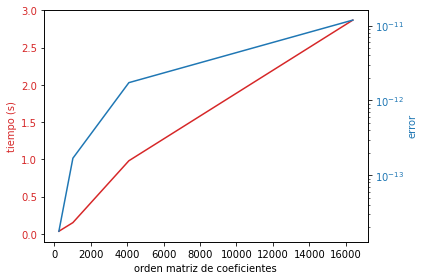

In [17]:
import time as tm
N = [4,4,4]
M = [4,4,4]
A_1 = kronecker_product(np.eye(2),np.array([[1,1],[1,-1]]))
A = [[A_1,A_1,A_1]]
itera_max = 100
tol = 1.0E-10
rank_max = 1000
e = 1.0E-8
a_imprimir=[]

for variable_no_usada in range(4,11):
    N.append(4)
    A[0].append(A_1)
    f = 1*np.ones(np.prod(N))
    start = tm.time()
    result = GROU_sep(f, A, e, tol, rank_max, itera_max, N=N, inner_procedure=ALS4)
    end = tm.time()
    a_imprimir.append([4**variable_no_usada,end-start,result[1]])



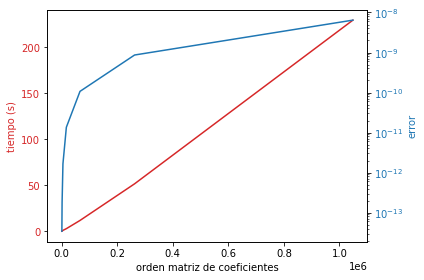

In [18]:
PLOT = list(np.array(a_imprimir).T)
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('orden matriz de coeficientes')
ax1.set_ylabel('tiempo (s)', color=color)
ax1.plot(PLOT[0], PLOT[1], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('error', color=color)  # we already handled the x-label with ax1
ax2.semilogy(PLOT[0], PLOT[2], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("tocho.pdf", format="pdf", bbox_inches="tight")
plt.show()